Assignment 2: Clustering: Sessa Empirical Estimator

Delgado, Nic Leander
Sia, Mary Joy

In [31]:
# Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

C:\Users\Joy\AppData\Local\Temp\ipykernel_2404\3353407480.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  random_df = df.groupby('pnr', group_keys=False).apply(lambda x: x.sample(1, random_state=1234)).reset_index(drop=True)


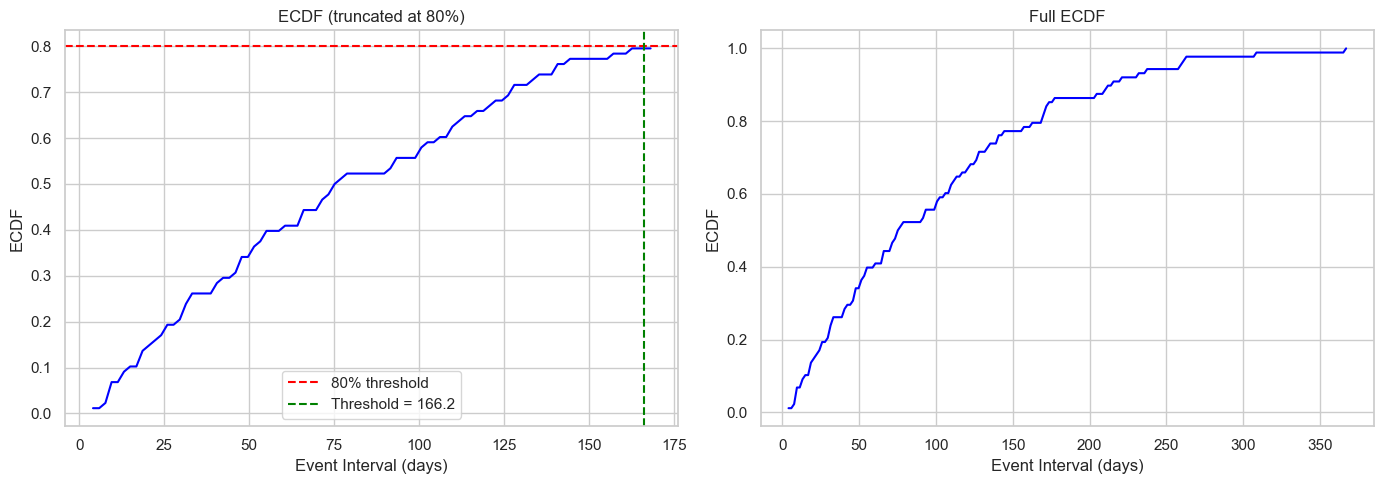

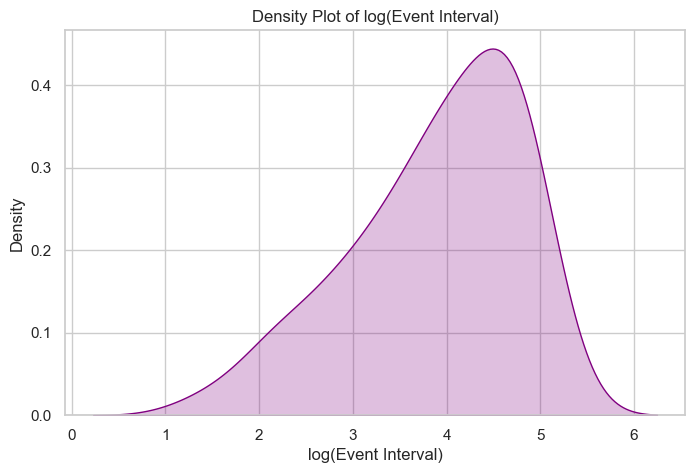

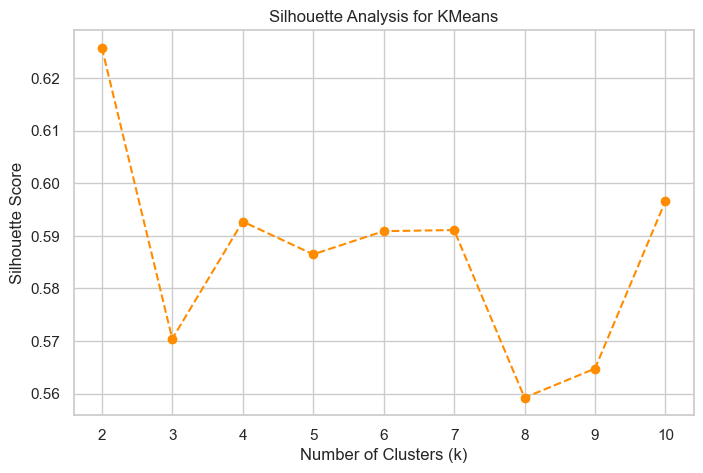

Results using KMeans clustering:
   pnr  event_interval  cluster  computed_duration                  method
0    2              50        0               90.0  KMeans (optimal k = 2)
1    5              39        0               90.0  KMeans (optimal k = 2)
2    6              76        0               90.0  KMeans (optimal k = 2)
3    7             116        0               90.0  KMeans (optimal k = 2)
4    8              17        1               17.0  KMeans (optimal k = 2)


C:\Users\Joy\AppData\Local\Temp\ipykernel_2404\3353407480.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  random_df = df.groupby('pnr', group_keys=False).apply(lambda x: x.sample(1, random_state=1234)).reset_index(drop=True)


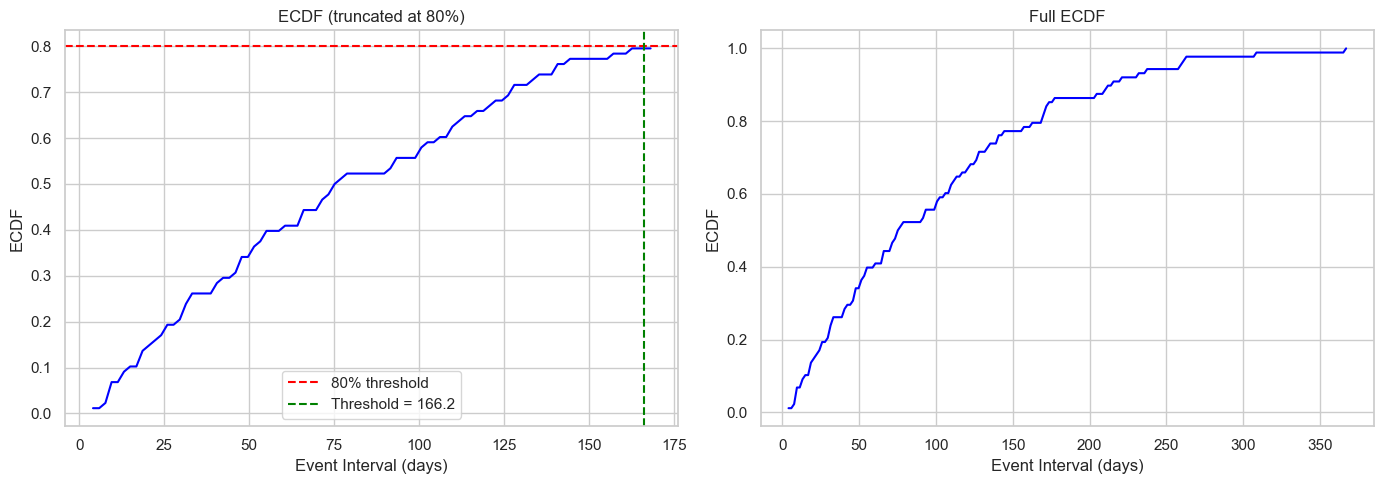

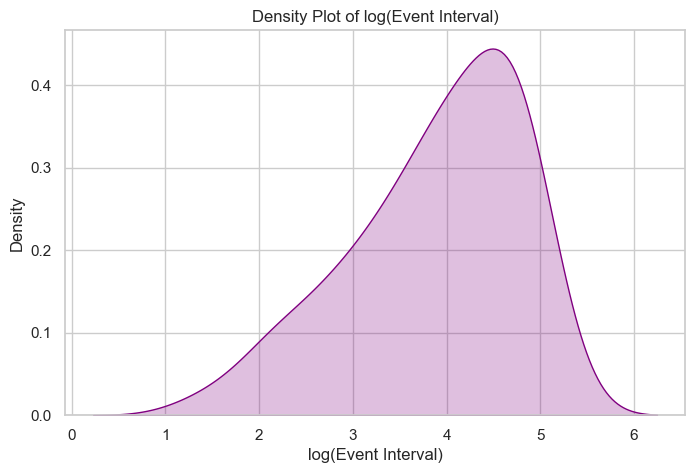


Results using Agglomerative Clustering:
   pnr  event_interval  cluster  computed_duration  \
0    2              50        1           55.00000   
1    5              39        1           55.00000   
2    6              76        1           55.00000   
3    7             116        2          117.98305   
4    8              17        0           17.00000   

                                              method  
0  Agglomerative (n_clusters = 3, silhouette = 0.56)  
1  Agglomerative (n_clusters = 3, silhouette = 0.56)  
2  Agglomerative (n_clusters = 3, silhouette = 0.56)  
3  Agglomerative (n_clusters = 3, silhouette = 0.56)  
4  Agglomerative (n_clusters = 3, silhouette = 0.56)  

Average computed duration using KMeans: 66.0 days
Average computed duration using Agglomerative Clustering: 64.1 days


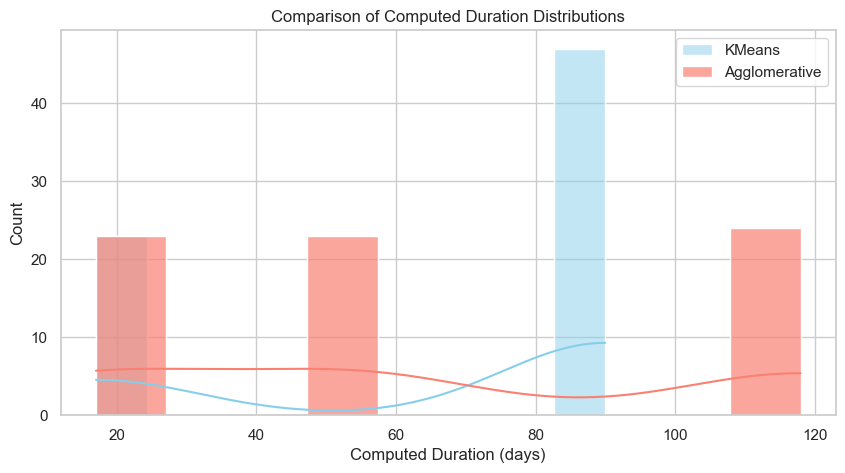

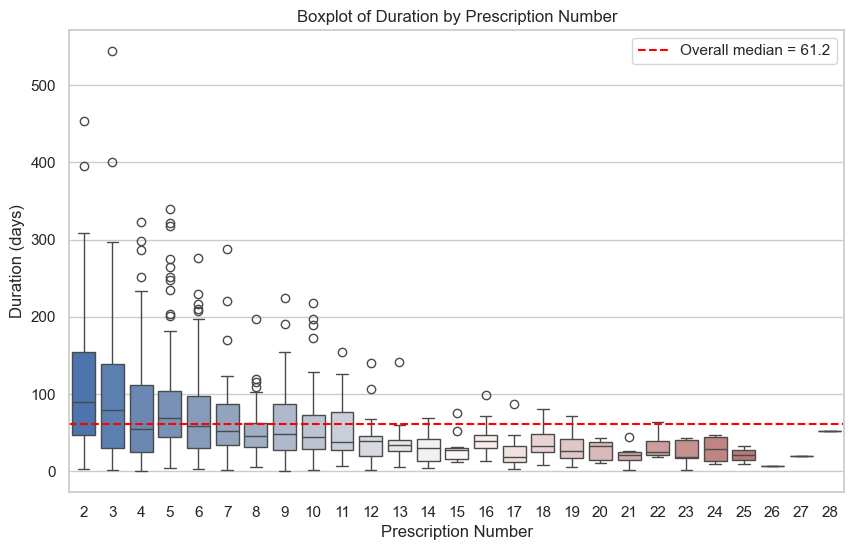

In [38]:
# %% [code]
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from statsmodels.distributions.empirical_distribution import ECDF
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set seaborn style (mimics sample notebook)
sns.set(style="whitegrid", context="notebook")

# %% [code]
# Step 1. Data Preprocessing: Load CSV files

def read_and_prepare_data(csv_path):
    """
    Reads the CSV file containing medication events and renames columns to standard names.
    Assumes the CSV contains columns: [pnr, eksd, perday, ATC, dur_original].
    Converts the date column 'eksd' to datetime.
    """
    df = pd.read_csv(csv_path)
    # Ensure column names are standardized
    df.columns = ['pnr', 'eksd', 'perday', 'ATC', 'dur_original']
    df['eksd'] = pd.to_datetime(df['eksd'], errors='coerce')
    return df

def load_atc_data(csv_path):
    """
    Loads the ATC data CSV (if needed for additional ATC code information).
    """
    atc_df = pd.read_csv(csv_path)
    return atc_df

# Load the provided CSV files.
# Update the file paths as needed.
df_med = read_and_prepare_data("med.events.csv")
df_atc = load_atc_data("med.events.ATC.csv")  # Optional: use as needed

# %% [code]
# Step 2. Compute Event Intervals

def compute_event_intervals(df, atc_code):
    """
    Filters the events data by a given ATC code, sorts by patient and date,
    computes the previous prescription date per patient,
    and calculates the event interval (in days) between consecutive prescriptions.
    """
    df_atc_filtered = df[df['ATC'] == atc_code].copy()
    df_atc_filtered.sort_values(['pnr', 'eksd'], inplace=True)
    df_atc_filtered['prev_eksd'] = df_atc_filtered.groupby('pnr')['eksd'].shift(1)
    df_atc_filtered = df_atc_filtered.dropna(subset=['prev_eksd']).copy()
    df_atc_filtered['event_interval'] = (df_atc_filtered['eksd'] - df_atc_filtered['prev_eksd']).dt.days
    return df_atc_filtered

# %% [code]
# Step 3. Select a Random Pair per Patient

def select_random_event(df):
    """
    For each patient, randomly select one row (i.e. one pair of consecutive prescriptions)
    to avoid overrepresentation from patients with many events.
    The use of group_keys=False prevents grouping keys from being added to the index.
    """
    random_df = df.groupby('pnr', group_keys=False).apply(lambda x: x.sample(1, random_state=1234)).reset_index(drop=True)
    return random_df

# %% [code]
# Step 4. Plot ECDF Panels

def plot_ecdf_panels(intervals, quantile=0.8):
    """
    Creates a two-panel figure:
      - Left panel: ECDF truncated at the 80% quantile.
      - Right panel: Full ECDF.
    Returns the threshold value corresponding to the quantile.
    """
    ecdf_full = ECDF(intervals)
    x_full = np.linspace(min(intervals), max(intervals), num=200)
    y_full = ecdf_full(x_full)
    
    threshold = np.percentile(intervals, quantile * 100)
    mask = y_full <= quantile
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left panel: Truncated ECDF
    axes[0].plot(x_full[mask], y_full[mask], color="blue")
    axes[0].axhline(quantile, color="red", linestyle="--", label="80% threshold")
    axes[0].axvline(threshold, color="green", linestyle="--", label=f"Threshold = {threshold:.1f}")
    axes[0].set_xlabel("Event Interval (days)")
    axes[0].set_ylabel("ECDF")
    axes[0].set_title("ECDF (truncated at 80%)")
    axes[0].legend()
    
    # Right panel: Full ECDF
    axes[1].plot(x_full, y_full, color="blue")
    axes[1].set_xlabel("Event Interval (days)")
    axes[1].set_ylabel("ECDF")
    axes[1].set_title("Full ECDF")
    
    plt.tight_layout()
    plt.show()
    return threshold

# %% [code]
# Step 5. Density Plot of log(Event Interval)

def plot_density_log_interval(intervals):
    """
    Plots a density plot of the log-transformed event intervals.
    """
    plt.figure(figsize=(8, 5))
    sns.kdeplot(np.log(intervals), shade=True, color="purple")
    plt.xlabel("log(Event Interval)")
    plt.title("Density Plot of log(Event Interval)")
    plt.show()

# %% [code]
# Step 6. Silhouette Analysis for KMeans

def plot_silhouette_analysis(intervals, k_range=range(2, 11)):
    """
    Computes silhouette scores for KMeans clustering on log-transformed intervals and
    plots the silhouette score versus the number of clusters.
    Returns the optimal k (highest silhouette score).
    """
    log_intervals = np.log(intervals.values.reshape(-1, 1))
    scores = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=1234).fit(log_intervals)
        score = silhouette_score(log_intervals, km.labels_)
        scores.append(score)
    
    plt.figure(figsize=(8, 5))
    plt.plot(list(k_range), scores, marker="o", linestyle="--", color="darkorange")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Analysis for KMeans")
    plt.xticks(list(k_range))
    plt.show()
    
    best_k = k_range[np.argmax(scores)]
    return best_k

# %% [code]
# Step 7. Clustering Functions

def cluster_intervals_kmeans(intervals, k_range=range(2, 11)):
    """
    Clusters the log-transformed event intervals using KMeans.
    Uses silhouette analysis to select the optimal number of clusters.
    Returns:
      - best_k: optimal number of clusters,
      - labels: cluster labels,
      - cluster_info: dictionary with median, min, and max (back-transformed) for each cluster.
    """
    log_intervals = np.log(intervals.values.reshape(-1, 1))
    best_k = plot_silhouette_analysis(intervals, k_range=k_range)
    
    km = KMeans(n_clusters=best_k, random_state=1234).fit(log_intervals)
    labels = km.labels_
    
    df_temp = pd.DataFrame({'log_interval': log_intervals.flatten(), 'cluster': labels})
    cluster_medians = df_temp.groupby('cluster')['log_interval'].median().apply(np.exp)
    cluster_bounds = df_temp.groupby('cluster')['log_interval'].agg(['min', 'max']).apply(lambda x: np.exp(x))
    cluster_info = {cl: {'median': cluster_medians[cl],
                         'min': cluster_bounds.loc[cl, 'min'],
                         'max': cluster_bounds.loc[cl, 'max']}
                    for cl in cluster_medians.index}
    return best_k, labels, cluster_info

def cluster_intervals_agglomerative(intervals, n_clusters=3):
    """
    Clusters the log-transformed event intervals using Agglomerative Clustering.
    Returns:
      - labels: cluster labels,
      - cluster_info: dictionary with median, min, and max for each cluster,
      - silhouette: silhouette score for the clustering.
    """
    log_intervals = np.log(intervals.values.reshape(-1, 1))
    agg = AgglomerativeClustering(n_clusters=n_clusters).fit(log_intervals)
    labels = agg.labels_
    sil = silhouette_score(log_intervals, labels)
    
    df_temp = pd.DataFrame({'log_interval': log_intervals.flatten(), 'cluster': labels})
    cluster_medians = df_temp.groupby('cluster')['log_interval'].median().apply(np.exp)
    cluster_bounds = df_temp.groupby('cluster')['log_interval'].agg(['min', 'max']).apply(lambda x: np.exp(x))
    cluster_info = {cl: {'median': cluster_medians[cl],
                         'min': cluster_bounds.loc[cl, 'min'],
                         'max': cluster_bounds.loc[cl, 'max']}
                    for cl in cluster_medians.index}
    return n_clusters, labels, cluster_info, sil

# %% [code]
# Step 8. Assign Computed Duration

def assign_computed_duration(random_df, labels, cluster_info):
    """
    Assigns to each event the computed duration based on its cluster's median.
    Returns a DataFrame with patient ID, observed event interval, cluster, and computed duration.
    """
    df_result = random_df.copy().reset_index(drop=True)
    df_result['cluster'] = labels
    df_result['computed_duration'] = df_result['cluster'].apply(lambda cl: cluster_info[cl]['median'])
    return df_result[['pnr', 'event_interval', 'cluster', 'computed_duration']]

# %% [code]
# Step 9. The Full Sessa Empirical Estimator Pipeline

def sessa_empirical_estimator(df, atc_code, clustering_method="kmeans", alt_n_clusters=3, quantile=0.8, plot_ecdf_flag=True):
    """
    Full pipeline for the Sessa Empirical Estimator (SEE):
      1. Filters data by ATC code and computes event intervals.
      2. For each patient, selects one random event.
      3. Plots ECDF panels and trims intervals at the specified quantile (default 80%).
      4. Optionally plots density of log(event_interval).
      5. Clusters the log(event_interval) using the chosen method ("kmeans" or "agglomerative").
      6. Assigns the computed duration (median of the cluster) to each event.
    Returns a DataFrame with patient ID, observed event interval, cluster assignment, computed duration, and method used.
    """
    # Compute event intervals for the specified ATC code
    df_events = compute_event_intervals(df, atc_code)
    # Select one random event per patient
    df_random = select_random_event(df_events)
    
    # Plot ECDF panels and trim intervals
    if plot_ecdf_flag:
        threshold = plot_ecdf_panels(df_random['event_interval'], quantile=quantile)
    else:
        threshold = np.percentile(df_random['event_interval'], quantile * 100)
    df_filtered = df_random[df_random['event_interval'] <= threshold].copy()
    
    # Plot density of log(event_interval)
    plot_density_log_interval(df_filtered['event_interval'])
    
    # Cluster the filtered event intervals using the chosen method
    if clustering_method.lower() == "kmeans":
        best_k, labels, cluster_info = cluster_intervals_kmeans(df_filtered['event_interval'])
        method_used = f"KMeans (optimal k = {best_k})"
    elif clustering_method.lower() == "agglomerative":
        n_clusters, labels, cluster_info, sil_score = cluster_intervals_agglomerative(df_filtered['event_interval'], n_clusters=alt_n_clusters)
        method_used = f"Agglomerative (n_clusters = {n_clusters}, silhouette = {sil_score:.2f})"
    else:
        raise ValueError("Invalid clustering method. Choose 'kmeans' or 'agglomerative'.")
    
    # Assign computed duration based on cluster medians
    df_result = assign_computed_duration(df_filtered, labels, cluster_info)
    df_result['method'] = method_used
    return df_result

# %% [code]
# Step 10. Plot Boxplot for Prescription Duration Assumption

def plot_assumption_boxplot(df):
    """
    Creates a boxplot similar to the R 'see_assumption' plot:
      - Computes a sequential prescription number per patient.
      - Calculates the duration between consecutive prescriptions.
      - Plots a boxplot of Duration vs. Prescription Number with an overall median line.
    """
    df_sorted = df.sort_values(['pnr', 'eksd']).copy()
    df_sorted['p_number'] = df_sorted.groupby('pnr').cumcount() + 1
    df_sorted['prev_eksd'] = df_sorted.groupby('pnr')['eksd'].shift(1)
    df_sorted = df_sorted.dropna(subset=['prev_eksd'])
    df_sorted['Duration'] = (df_sorted['eksd'] - df_sorted['prev_eksd']).dt.days
    
    # Compute median duration per patient and overall median
    medians = df_sorted.groupby('pnr')['Duration'].median().reset_index(name='median_duration')
    overall_median = medians['median_duration'].median()
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=df_sorted, palette="vlag")
    plt.axhline(overall_median, color="red", linestyle="--", label=f"Overall median = {overall_median:.1f}")
    plt.xlabel("Prescription Number")
    plt.ylabel("Duration (days)")
    plt.title("Boxplot of Duration by Prescription Number")
    plt.legend()
    plt.show()

# %% [code]
# Step 11. Run the Pipeline and Compare Clustering Methods Using Provided CSV Data

# Choose an ATC code for filtering (adjust this value as needed; for example, "medA")
atc_code_of_interest = "medA"

# Run the SEE pipeline using KMeans clustering:
result_kmeans = sessa_empirical_estimator(df_med, atc_code=atc_code_of_interest, clustering_method="kmeans")
print("Results using KMeans clustering:")
print(result_kmeans.head())

# Run the SEE pipeline using Agglomerative Clustering:
result_agglo = sessa_empirical_estimator(df_med, atc_code=atc_code_of_interest, clustering_method="agglomerative", alt_n_clusters=3)
print("\nResults using Agglomerative Clustering:")
print(result_agglo.head())

# Generate insights: Compare average computed durations between methods.
avg_duration_kmeans = result_kmeans['computed_duration'].mean()
avg_duration_agglo = result_agglo['computed_duration'].mean()
print(f"\nAverage computed duration using KMeans: {avg_duration_kmeans:.1f} days")
print(f"Average computed duration using Agglomerative Clustering: {avg_duration_agglo:.1f} days")

# Additional insight: Plot distribution of computed durations for both methods.
plt.figure(figsize=(10, 5))
sns.histplot(result_kmeans['computed_duration'], bins=10, color="skyblue", label="KMeans", kde=True)
sns.histplot(result_agglo['computed_duration'], bins=10, color="salmon", label="Agglomerative", kde=True, alpha=0.7)
plt.xlabel("Computed Duration (days)")
plt.title("Comparison of Computed Duration Distributions")
plt.legend()
plt.show()

# Plot the boxplot for the prescription duration assumption using the med.events.csv data.
plot_assumption_boxplot(df_med)
